In [1]:
import os
import copy
import torch
import detectron2
import wandb
import json
import pandas as pd
import matplotlib.pyplot as plt
from detectron2.data import detection_utils as utils
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader, build_detection_train_loader

In [2]:
# Register Dataset
register_coco_instances('coco_trash_train', {}, '../../new_dataset2/0/train.json', '../../new_dataset2/0/')
register_coco_instances('coco_trash_test', {}, '../../new_dataset2/0/val.json', '../../new_dataset2/0/')

MetadataCatalog.get('coco_trash_train').thing_classes = ["General trash", "Paper", "Paper pack", "Metal", 
                                                         "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

In [3]:
# config 불러오기
cfg = get_cfg()

# faster_rcnn_x_101_32x8d_FPN_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml'))

# cascade_mask_rcnn_X_152_32x38d_FPN_IN5k_gn_dconv.yaml
#cfg.merge_from_file(model_zoo.get_config_file('Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml'))

In [4]:
# config 수정하기
cfg.DATASETS.TRAIN = ('coco_trash_train',)
cfg.DATASETS.TEST = ('coco_trash_test',)

with open('/opt/ml/new_dataset2/0/train.json', 'r') as json_reader:
    train_dataset = json.load(json_reader)
with open('/opt/ml/new_dataset2/0/val.json', 'r') as json_reader:
    val_dataset = json.load(json_reader)

# -----------------------------------------------------------------------------
# INPUT
# -----------------------------------------------------------------------------
cfg.INPUT.MIN_SIZE_TRAIN = (1024,)
cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice" # choice, random, range
cfg.INPUT.MAX_SIZE_TRAIN = 1024
cfg.INPUT.MIN_SIZE_TEST  = 0                 # set 0 to disable resize in testing
cfg.INPUT.MAX_SIZE_TEST  = 1024
cfg.INPUT.RANDOM_FLIP = "None"               # with probability of 0.5

# -----------------------------------------------------------------------------
# DataLoader
# -----------------------------------------------------------------------------
cfg.DATASETS.NUMOFTRAIN = len(train_dataset['images'])
cfg.DATASETS.NUMOFVAL = len(val_dataset['images'])

cfg.DATALOADER.NUM_WORKERS = 0
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler" # Options: TrainingSampler, RepeatFactorTrainingSampler
cfg.DATALOADER.REPEAT_THRESHOLD = 0.14                       # Repeat threshold for RepeatFactorTrainingSampler

# ---------------------------------------------------------------------------- #
# Backbone options
# ---------------------------------------------------------------------------- #
cfg.MODEL.BACKBONE.FREEZE_AT = 0

# ---------------------------------------------------------------------------- #
# Proposal generator options
# ---------------------------------------------------------------------------- #
cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RPN" # Current proposal generators include "RPN", "RRPN" and "PrecomputedProposals"

# ---------------------------------------------------------------------------- #
# FPN options
# ---------------------------------------------------------------------------- #
cfg.MODEL.FPN.NORM = "GN"         # (no norm), "GN"
cfg.MODEL.FPN.FUSE_TYPE = "sum" # sum of avg (fusing the FPN top-down and lateral features)

# ---------------------------------------------------------------------------- #
# RPN options
# ---------------------------------------------------------------------------- #
cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = "ciou" # smooth_l1, giou, diou, ciou

# ---------------------------------------------------------------------------- #
# ROI Head & Box Head options
# ---------------------------------------------------------------------------- #
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "ciou"  # smooth_l1, giou, diou, ciou
cfg.MODEL.ROI_BOX_HEAD.NORM = "GN"                    # Options: "" (no norm), "GN", "SyncBN".
cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = True # Whether to use class agnostic for bbox regression
cfg.MODEL.ROI_BOX_HEAD.TRAIN_ON_PRED_BOXES = False  # If true, RoI heads use bounding boxes predicted by the box head rather than proposal boxes.

# ---------------------------------------------------------------------------- #
# Anchor generator options
# ---------------------------------------------------------------------------- #
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128, 256, 512]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIO = [[0.5, 1.0, 2.0]]
cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[-90, 0, 90]]
cfg.MODEL.ANCHOR_GENERATOR.OFFSET = 0.5 # recommend to use 0.5

# ---------------------------------------------------------------------------- #
# ResNe[X]t options (ResNets = {ResNet, ResNeXt}
# Note that parts of a resnet may be used for both the backbone and the head
# These options apply to both
# ---------------------------------------------------------------------------- #
#cfg.MODEL.RESNETS.NORM = "FrozenBN"                                  # FrozenBN, GN, SyncBN, BN
#cfg.MODEL.RESNETS.DEFORM_ON_PER_STAGE = [False, True, True, True]    # Apply Deformable Convolution in stages. Specify if apply deform_conv on Res2, Res3, Res4, Res5
#cfg.MODEL.RESNETS.DEFORM_MODULATED = False                           # Use False for DeformableV1. True for Deformable2 (modulated deform_conv)
#cfg.MODEL.RESNETS.DEFORM_NUM_GROUPS = 1                              # Number of groups in deformable conv.

# ---------------------------------------------------------------------------- #
# Solver
# ---------------------------------------------------------------------------- #
cfg.LR_SCHEDULER_NAME = "WarmupMultiStepLR" # WarmupMultiStepLR, WarmupCosineLR
cfg.SOLVER.EPOCHS = 20 # 20 epoch ~24,000K steps
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.CHECKPOINT_PERIOD = int(len(train_dataset['images']) / cfg.SOLVER.IMS_PER_BATCH)
cfg.SOLVER.MAX_ITER = int(cfg.SOLVER.EPOCHS * cfg.DATASETS.NUMOFTRAIN / cfg.SOLVER.IMS_PER_BATCH) # default 270,000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (6000,12000,18000,24000,30000,) 
cfg.SOLVER.GAMMA = 0.8
cfg.SOLVER.NESTEROV = False
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.WEIGHT_DECAY_NORM = 0.0
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.AMP.ENABLED = True

# ---------------------------------------------------------------------------- #
# Specific test options
# ---------------------------------------------------------------------------- #
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml')
cfg.OUTPUTNAME = 'Testing...'
cfg.OUTPUT_DIR = f'./output_{cfg.OUTPUTNAME}'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # Default is 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
cfg.TEST.EVAL_PERIOD = int(len(train_dataset['images']) / cfg.SOLVER.IMS_PER_BATCH)

In [5]:
int(len(train_dataset['images']) / cfg.SOLVER.IMS_PER_BATCH)

3914

### Custom Mapper
---

In [6]:
import numpy as np
import math
h,w,lamb = 1024, 1024, 0.5

cut_ratio = math.sqrt(1.0-lamb)
cut_h = int(h * cut_ratio)
cut_w = int(w * cut_ratio)
center_x = np.random.randint(w)
center_y = np.random.randint(h)

bbx1 = np.clip(center_x - cut_w // 2, 0, w)
bby1 = np.clip(center_y - cut_h // 2, 0, h)
bbx2 = np.clip(center_x + cut_w // 2, 0, w)
bby2 = np.clip(center_y + cut_h // 2, 0, h)
print(cut_h, cut_w)
print(center_x, center_y)
print(bbx1, bby1, bbx2, bby2) # xmin, ymin, xmax, ymax

724 724
35 640
0 278 397 1002


In [12]:
import albumentations as A
import detectron2.data.transforms as T
import math
import numpy as np

class CutOut(T.Augmentation):

    def __init__(self, alpha):
        self.alpha    = alpha
        self._init(locals())

    def rand_bbox(self, img, alpha):
        '''
        img: image to be applied
        alpha: cut ratio parameter (0.0~1.0)
        '''
        h, w, _ = img.shape
        cut_ratio = (1.0-alpha)
        cut_h = int(h * cut_ratio)
        cut_w = int(w * cut_ratio)

        center_x = np.random.randint(w)
        center_y = np.random.randint(h)

        bbx1 = np.clip(center_x - cut_w // 2, 0, w)
        bby1 = np.clip(center_y - cut_h // 2, 0, h)
        bbx2 = np.clip(center_x + cut_w // 2, 0, w)
        bby2 = np.clip(center_y + cut_h // 2, 0, h)

        return bbx1, bby1, bbx2, bby2

    def get_transform(self, image):
        xmin, ymin, xmax, ymax = self.rand_bbox(image, self.alpha)
        return CutOutTransform(self.alpha, xmin, ymin, xmax, ymax)
    
class CutOutTransform(T.Transform):

    def __init__(self, alpha, xmin, ymin, xmax, ymax):
        super().__init__()
        self.alpha = alpha
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self._set_attributes(locals())

    def apply_image(self, img):
        image_copy = img.copy()
        transform = A.Compose([A.GaussNoise(var_limit=(50,100), mean=0, p=1.0),
                               A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0)])
        augmented_image = transform(image=image_copy)['image']
        augmented_image[self.xmin:self.xmax, self.ymin:self.ymax] = 0
        return augmented_image

    def apply_coords(self, coords):
        return coords
    
    def apply_box(self, box): # xmin, ymin, w, h
        new_box = box.copy()
        print(new_box[0][0] >= self.xmin)
        print(new_box[0][1] >= self.ymin)
        print(new_box[0][0]+new_box[0][2] <= self.xmax)
        print(new_box[0][1]+new_box[0][3] <= self.ymax)
        print()
        if new_box[0][0] >= self.xmin and new_box[0][1] >= self.ymin and new_box[0][0] <= self.xmax and new_box[0][1] <= self.ymax:
            new_box[0][0]=0
            new_box[0][1]=0
            new_box[0][2]=0
            new_box[0][3]=0
        return new_box
    
      #[[371.8999939  402.70001221 604.40002441 631.90002441]]
#[[360.70001221 468.6000061  623.30004883 623.79998779]]

In [13]:
# mapper - input data를 어떤 형식으로 return할지 (따라서 augmnentation 등 데이터 전처리 포함 됨)
def MyMapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict['file_name'], format='BGR')
    print(dataset_dict)

    transform_list=[CutOut(0.5), T.RandomFlip(1.0)]
    
    image, transforms = T.apply_transform_gens(transform_list, image)
    
    dataset_dict['image'] = torch.as_tensor(image.transpose(2,0,1).astype('float32'))
    
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2]) # transform annotations 
        for obj in dataset_dict.pop('annotations')
        if obj.get('iscrowd', 0) == 0
    ]
    
    instances = utils.annotations_to_instances(annos, image.shape[:2]) # create the instances that are forwared to the model
    dataset_dict['instances'] = utils.filter_empty_instances(instances)
    
    return dataset_dict

In [29]:
from detectron2.solver.build import maybe_add_gradient_clipping, get_default_optimizer_params

# trainer - DefaultTrainer를 상속
class MyTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
        cfg, mapper = MyMapper, sampler = sampler
        )
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs('./output_eval', exist_ok = True)
            output_folder = './output_eval'
            
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# {'file_name': '../../new_dataset2/0/train/3722.jpg', 'height': 1024, 'width': 1024, 'image_id': 3722, 'annotations': [{'iscrowd': 0, 'bbox': [789.6, 384.2, 234.1, 460.2], 'category_id': 7, 'bbox_mode': <BoxMode.XYWH_ABS: 1>},

In [32]:
test_loader = build_detection_train_loader(cfg, MyMapper)
data_iter = iter(test_loader)
batch = next(data_iter)

[05/13 19:34:16 d2.data.datasets.coco]: Loaded 3914 images in COCO format from ../../new_dataset2/0/train.json
[05/13 19:34:16 d2.data.build]: Removed 0 images with no usable annotations. 3914 images left.
[05/13 19:34:16 d2.data.build]: Using training sampler RepeatFactorTrainingSampler
[05/13 19:34:16 d2.data.common]: Serializing 3914 elements to byte tensors and concatenating them all ...
[05/13 19:34:16 d2.data.common]: Serialized dataset takes 1.78 MiB
{'file_name': '../../new_dataset2/0/train/0761.jpg', 'height': 1024, 'width': 1024, 'image_id': 761, 'annotations': [{'iscrowd': 0, 'bbox': [167.9, 370.5, 241.0, 471.7], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [393.7, 541.1, 201.7, 198.1], 'category_id': 7, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [545.8, 180.5, 402.3, 691.1], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [675.6, 380.6, 129.5, 40.6], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_

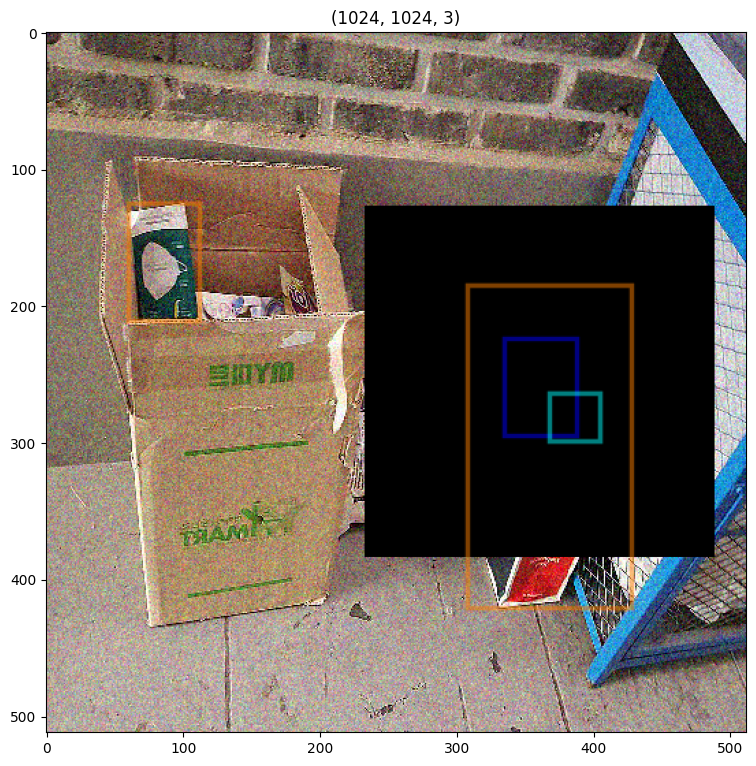

In [33]:
# visualization

rows, cols = 1, 2
plt.figure(figsize=(20,20))
my_dataset_train_metadata = MetadataCatalog.get("coco_trash_train")

for i, per_image in enumerate(batch): # will only show 4 images because IMS_PER_BATCH is set to 4
  
    plt.subplot(2, 2, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=my_dataset_train_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image())
    plt.title(img.shape)

---